# Gitcoin Dynamical Network generation

On this notebook, we use a cadCAD model for retrieving the first 6000 contribution events from Gitcoin Grants Round 8. We generate a dynamical network where we have a NetworkX Digraph for each sequential point. 

We also calculate the CLR match and the theoretical match (match before normalization) for each point on time. We perform a A/B test in regards to the presence of the user pairwise comparison term.


## cadCAD Model Structure Overview 
In the cadCAD simulation methodology, we operate on four layers: Policies, Mechanisms, States, and Metrics. Information flows do not have explicit feedback loop unless noted. Policies determine the inputs into the system dynamics, and can come from user input, observations from the exogenous environment, or algorithms. Mechanisms (sometimes referred to as State Update Logic) are functions that take the policy decisions and update the States to reflect the policy level changes. States are variables that represent the system quantities at the given point in time, and Metrics are computed from state variables to assess the health of the system, essentially views on a complex data structure. Metrics can often be thought of as Key Performance Indicators (KPIs).

At a more granular level, to setup a model, there are system conventions and configurations that must be [followed](https://community.cadcad.org/t/introduction-to-simulation-configurations/34).

The way to think of cadCAD modeling is analogous to machine learning pipelines which normally consist of multiple steps when training and running a deployed model. There is preprocessing, which includes segregating features between continuous and categorical, transforming or imputing data, and then instantiating, training, and running a machine learning model with specified hyperparameters. cadCAD modeling can be thought of in the same way as states, roughly translating into features, are fed into pipelines that have built-in logic to direct traffic between different mechanisms, such as scaling and imputation. Accuracy scores, ROC, etc. are analogous to the metrics that can be configured on a cadCAD model, specifying how well a given model is doing in meeting its objectives. The parameter sweeping capability of cadCAD can be thought of as a grid search, or way to find the optimal hyperparameters for a system by running through alternative scenarios. A/B style testing that cadCAD enables is used in the same way machine learning models are A/B tested, except out of the box, in providing a side by side comparison of muliple different models to compare and contrast performance. Utilizing the field of Systems Identification, dynamical systems models can be used to "online learn" by providing a feedback loop to generative system mechanisms.

cadCAD models are micro founded with metrics being at the macro or the institutional level. If you are interested in institutional dynamics, see Dr. Zargham's recent paper: [Voshmgir, Shermin and Zargham, Michael (2019) Foundations of Cryptoeconomic Systems. Working Paper Series / Institute for Cryptoeconomics / Interdisciplinary Research, 1. Research Institute for Cryptoeconomics, Vienna](https://epub.wu.ac.at/7309/).



## Model File structure
* dynamic_network.ipynb
* model/
* [env_config.py](env_config.py)
* [run_simulation.py](run_simulation.py)
* [prepare_data.py](prepare_data.py)

[run_simulation.py](run_simulation.py) is used to run the simulation and save the results as a pickle file for ease of analysis. [env_config.py](env_config.py) is used to configure the environment and define where the pickled simulation results are. [prepare_data.py](prepare_data.py) is used to anonymize the initial .csv data to protect the gitcoin participant's privacy.

In the model folder there exist 5 files, a parts folder and a data folder, the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), [state_variables.py](state_variables.py), and [sys_params.py](model/sys_params.py). The [config.py](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [partial_state_update_block.py](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [state_variables.py](model/state_variables.py) defines the state variables and [run.py](model/run.py) actually runs the simulation. 

The mechanisms of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)

The initial parameters and hyperparameters of the system are defined in sys_params.py and helper functions, plots, trigger function, etc. are in the utils.py.

**Note:**
When running this notebook simulation, be sure to run from "Kernal" -> "Restart & Run All"



In [1]:
## Load data from pickle file
The model results have been pre-computed as a pickle file to save time for the user. For analyzing the network, there is no need to rerun the cadCAD model to conver the raw .csv or excel data to the pickled file. If the user would like to do so, they could by running the following:

```
python run_simulation.py
```

**Note:** The simulation is rather large, and may take several minutes to run, depending on your computer's RAM and CPU.

SyntaxError: invalid syntax (<ipython-input-1-879f09a1d90e>, line 2)

In [2]:
%load_ext autotime
import matplotlib.pyplot as plt
from collections import defaultdict
from model.parts.utils import *
import networkx as nx
import plotly.express as px
import pandas as pd
import cloudpickle
import inequality_coefficients as ineq
from env_config import PICKLE_PATH

import plotly.io as pio
pio.renderers.default = "jupyterlab"

with open(PICKLE_PATH, 'rb') as fid:
    result = cloudpickle.load(fid)

time: 10.1 s (started: 2021-02-23 10:33:03 +01:00)


## Data visualization
Below we will produce some plots to analyze the Gitcoin Grants Round 7 data

In [3]:
# extract data from result for plotly plotting
df = result.loc[(0, 0, 1, slice(None))]

time: 3.98 ms (started: 2021-02-23 10:33:43 +01:00)


In [4]:
df.head()

,contributions,pair_totals,quadratic_match,quadratic_funding_per_grant,quadratic_match_per_grant,quadratic_total_match,quadratic_total_funding,simple_quadratic_match,simple_quadratic_funding_per_grant,simple_quadratic_match_per_grant,simple_quadratic_total_match,simple_quadratic_total_funding
timestep,,,,,,,,,,,,
0,[],{},{},{},{},0.0,0.000000,{},{},{},0.000000,0.000000
1,"[{'time_sequence': 0, 'contributor': 'a0b99288...",{},{},{'Coin Center is educating policy makers about...,{'Coin Center is educating policy makers about...,0.0,1.130170,{},{'Coin Center is educating policy makers about...,{'Coin Center is educating policy makers about...,0.000000,1.130170
2,"[{'time_sequence': 0, 'contributor': 'a0b99288...",{},{},"{'Bankless': 1.130170028617465, 'Coin Center i...",{'Coin Center is educating policy makers about...,0.0,2.260340,{},"{'Bankless': 1.130170028617465, 'Coin Center i...",{'Coin Center is educating policy makers about...,0.000000,2.260340
3,"[{'time_sequence': 0, 'contributor': 'a0b99288...",{},{},"{'Bankless': 1.12754638597279, 'Coin Center is...",{'Coin Center is educating policy makers about...,1.3,3.555093,{},"{'Bankless': 1.0863451198953082, 'Coin Center ...",{'Coin Center is educating policy makers about...,80.037148,82.209838
4,"[{'time_sequence': 0, 'contributor': 'a0b99288...",{},{},"{'Bankless': 1.12754638597279, 'Coin Center is...",{'Coin Center is educating policy makers about...,1.3,4.682639,{},"{'Bankless': 1.0863451198953082, 'Coin Center ...",{'Coin Center is educating policy makers about...,80.037148,83.296183


time: 22.2 ms (started: 2021-02-18 08:45:48 +01:00)


### Timeseries for total amounts, Round-wide
#### Quadratic funding


In [4]:
fig_df = df.reset_index()

title = 'Total CLR match over time in USDT'

x_col = 'timestep'
y_cols = ['quadratic_total_funding']

labels = {'value': 'Amount in USDT',
          'timestep': 'Event sequence'}

options = {'x': x_col,
           'y': y_cols,
           'title': title,
           'labels': labels}

fig = px.line(fig_df, **options)

fig.show()

time: 876 ms (started: 2021-02-23 10:33:54 +01:00)


### Quadratic Funding with Pairwise term

In [5]:
fig = px.line(df.reset_index(),
              x='timestep',
              y=['quadratic_total_match', 'quadratic_total_funding'])

fig.show()

time: 124 ms (started: 2021-02-23 10:33:57 +01:00)


Based on the data above, we can see that the quadratic total funding is increasing almost linearly, with the quadratic_total_match starting relatively flat but matching the trend starting around timestep 60. 

In [6]:
y = df.quadratic_total_funding / df.quadratic_total_match
y.name = 'funding_per_match'
px.line(y.reset_index(),
        x='timestep',
        y='funding_per_match')

time: 359 ms (started: 2021-02-23 10:34:02 +01:00)


### Quadratic Funding without Pairwise term

In [7]:
fig = px.line(df.reset_index(),
              x='timestep',
              y=['simple_quadratic_total_match', 'simple_quadratic_total_funding'])
fig.show()

time: 120 ms (started: 2021-02-23 10:34:08 +01:00)


Without the pairwise term, the total match and total funding are equivalent 

In [8]:
y = df.simple_quadratic_total_funding / df.simple_quadratic_total_match
y.name = 'funding_per_match'
px.line(y.reset_index(),
        x='timestep',
        y='funding_per_match')

time: 84.1 ms (started: 2021-02-23 10:34:13 +01:00)


#### Total donations

In [9]:
contribs_total_donation = lambda contribs: sum(contrib['amount'] for contrib in contribs)
contrib_per_time = df.contributions.map(contribs_total_donation)
fig_df = contrib_per_time.reset_index()

title = 'Total donations over time in USDT'

x_col = 'timestep'
y_cols = ['contributions']

labels = {'value': 'Amount in USDT',
          'timestep': 'Event sequence'}

options = {'x': x_col,
           'y': y_cols,
           'title': title,
           'labels': labels}

fig = px.line(fig_df, **options)

fig.show()

time: 1.31 s (started: 2021-02-23 10:34:16 +01:00)


#### Gini index

In [10]:
contribs_total_donation = lambda contribs: ineq.gini([contrib['amount'] for contrib in contribs]) / len(contribs)
contrib_per_time = df.contributions.iloc[1:].map(contribs_total_donation)
contrib_per_time.name = 'contributions_gini'
fig_df = contrib_per_time.reset_index()

title = 'Gini index for the distribution of donations over time'

x_col = 'timestep'
y_cols = ['contributions_gini']

labels = {'value': 'Gini index',
          'timestep': 'Event sequence'}

options = {'x': x_col,
           'y': y_cols,
           'title': title,
           'labels': labels,
           'log_y': True}

fig = px.line(fig_df, **options)

fig.show()

time: 11.8 s (started: 2021-02-23 10:34:21 +01:00)


### Time interactive bar plots for the top 15 grants

In [11]:
N = 14

grant_dataset = defaultdict(list)
for i, row in tqdm(df.iterrows(), total=len(df)):
    if i == 0:
        continue
        
    # Donations
    metric_df = pd.DataFrame(row.contributions)
    s = metric_df.groupby('grant').amount.sum().sort_values()
    top_N = s.iloc[-N:]
    remaining = s.iloc[:-N].sum()
    metrics = pd.Series({**top_N.to_dict(), 'Others': remaining}).sort_values()
    el = {**top_N.to_dict(), 'Others': remaining.sum()}
    grant_dataset['agg_top_contribs'].append(el)
    grant_dataset['agg_contribs'].append(s.to_dict())
    
    # Unique contributors
    metric_df = pd.DataFrame(row.contributions)
    s = metric_df.groupby('grant').contributor.nunique().sort_values()
    top_N = s.iloc[-N:]
    remaining_indices = ~metric_df.grant.isin(top_N.index)
    remaining = metric_df[remaining_indices].contributor.nunique()
    metrics = pd.Series({**top_N.to_dict(), 'Others': remaining}).sort_values()
    el = {**top_N.to_dict(), 'Others': remaining}
    grant_dataset['agg_top_unique'].append(el)
    grant_dataset['agg_unique'].append(s.to_dict())

    # CLR match
    obj = row.quadratic_funding_per_grant
    s = pd.Series(obj).sort_values()
    top_N = s.iloc[-N:]
    remaining = s.iloc[:-N]
    el = {**top_N.to_dict(), 'Others': remaining.sum()}
    grant_dataset['agg_top_clr_funding'].append(el)
    grant_dataset['agg_clr_funding'].append(s.to_dict())
    
    # Simple CLR match
    obj = row.simple_quadratic_funding_per_grant
    s = pd.Series(obj).sort_values()
    top_N = s.iloc[-N:]
    remaining = s.iloc[:-N]
    el = {**top_N.to_dict(), 'Others': remaining.sum()}
    grant_dataset['agg_top_simple_clr_funding'].append(el)
    grant_dataset['agg_simple_clr_funding'].append(s.to_dict())

100%|██████████| 6001/6001 [01:18<00:00, 76.56it/s]time: 1min 18s (started: 2021-02-23 10:34:38 +01:00)



In [12]:
def cleanup(grant_dataset: dict, key: str) -> pd.DataFrame:
    df = (pd.DataFrame(grant_dataset[key])
            .unstack()
            .reset_index()
            .rename(columns={'level_0': 'grant',
                             'level_1': 'timestep',
                             0: key})
            .dropna())
    return df

grant_dfs = {k: cleanup(grant_dataset, k) for k in grant_dataset.keys()}

time: 3.17 s (started: 2021-02-24 13:28:09 +01:00)


#### CLR match gini index across grants 

In [13]:
key_1 = 'agg_clr_funding'
fig_df_1 = (grant_dfs[key_1]
            .sort_values(by=key_1)
            .groupby('timestep')[key_1]
            .apply(lambda s: ineq.gini(s) / len(s))
            .reset_index()
         )

key_2 = 'agg_contribs'
fig_df_2 = (grant_dfs[key_2]
            .sort_values(by=key_2)
            .groupby('timestep')[key_2]
            .apply(lambda s: ineq.gini(s) / len(s))
            .reset_index()
         )

key_3 = 'agg_simple_clr_funding'
fig_df_3 = (grant_dfs[key_3]
            .sort_values(by=key_3)
            .groupby('timestep')[key_3]
            .apply(lambda s: ineq.gini(s) / len(s))
            .reset_index()
         )

fig_df = (fig_df_1.set_index('timestep')
                  .join(fig_df_2.set_index('timestep'))
                  .join(fig_df_3.set_index('timestep'))
                  .reset_index())

title = 'Gini index for grants'

x_col = 'timestep'
y_cols = [key_1, key_2, key_3]

labels = {'value': 'Gini Index',
          'grant': ''}

options = {'x': x_col,
           'y': y_cols,
           'title': title,
           'labels': labels}

fig = px.scatter(fig_df, **options)

fig.show()

time: 4.32 s (started: 2021-02-17 17:40:32 +01:00)


#### Grant funding

In [14]:
import plotly.graph_objects as go

#########
# Data #
########
key = 'agg_top_clr_funding'
fig_df = (grant_dfs[key]
          .sort_values(by=key))


t_col = 'timestep'
N_points = 10
t = fig_df[t_col].unique()
f = int(len(t) / N_points)
sampled_timesteps = t[::f]
fig_df = (fig_df.set_index(t_col)
                .loc[sampled_timesteps]
                .reset_index()
                .sort_values(by=[t_col, key]))

time = fig_df[t_col].unique() # unique timesteps
x_col = 'grant'
y_cols = [key]


##############
# Constants  #
##############
title = 'CLR funding for the top 14 + others grants'
#title_x = 'grant' # if needed
title_y = 'CLR funding per grant (USDT)'
bar_color = 'mediumslateblue'
other_color = 'crimson'

transition_time = 2000 # for no animation set = 0
frame_time = 1000

nav_p_t = 70 #nav padding top
slider_p_t = 50 #slider padding top

padding_x_l = -0.5 
padding_x_r = 0.5

room_y = 1.1 # 20% room over max y
text_len = 10 # number of characters per line to put on the labels


###########
# sliders #
###########
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 10},
        "prefix": "timestamp=",
        "visible": True,
        "xanchor": "left"
    },
    "transition": {"duration": transition_time, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": slider_p_t, 'l':15 },
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

############################   
# Frames and sliders steps #
###########################
frames = []
max_x = len(fig_df[x_col].unique())
nb_grants_max = 0 # should be 15 in the end ...

for ts in time:
    go_data = fig_df.set_index(t_col).loc[ts] 
    table_x = go_data[x_col].tolist()
    
    # max x len calculation should be 15
    if len(table_x) > nb_grants_max:
        nb_grants_max = len(table_x)
    
    table_y = go_data[key].tolist()
    frame = go.Frame( name=str(ts),
                     data=[go.Bar( x=list(
                                         map( # 3 lines 
                                             lambda x : str(x[:text_len]) + '<br>' + 
                                             str(x[text_len:2*text_len]) + '<br>' + 
                                             str(x[2*text_len:3*text_len]), table_x)
                                   ), 
                                   y=table_y,
                                   customdata=table_x,
                                   hovertemplate = '<i>'+str(title_y)+'</i>: %{y:$,.2f}'+
                                                   '<br>%{customdata}' + '<extra></extra>',
                                   hovertext=table_x, 
                                   text=[ 'pos. '+ str(s) for s in reversed(range(1,len(table_x)+1)) ],
                                   textposition='outside', textangle=0, showlegend=False,
                                   marker_color=list( map(lambda x: bar_color if x != 'Others' else other_color, table_x) )
                                 )
                          ],            
                    layout=go.Layout( title_text=f" {title} at {ts} timestamp", 
                                      yaxis_range=[0,max(table_y)*room_y],
                                      yaxis_type='linear',
                                      # xaxis_range=[0, len(table_x)*room_x ]
                                    ),
                    ) # End frame
    frames.append(frame)
    
    # slider_step
    slider_step = { 'args': [ [ts],
            {'frame': {'duration': frame_time, 'redraw': True},
             'mode': 'immediate',
             'transition': {'duration': transition_time}},
            { 'yaxis': {'title': title_y + '<br>(linear scale---)', 'type': 'linear'} } ],
             'label': str(ts),
             'method': 'animate'}
    sliders_dict["steps"].append(slider_step)
    
    
#################
# NAV BOUTTONS #
################
nav_bouttons =   {
        'buttons': [
            #LOG SCALE
            {
                'args': [ {'yaxis': {'title': title_y + '<br>(log scale)', 'type': 'log'}}],
                'label':'Log',
                'method':'relayout'
            },
            #LINEAR SCALE
            {
                'args': [ {'yaxis': {'title': title_y + '<br>(linear scale)', 'type': 'linear'}}],
                'label':'Linear',
                'method':'relayout'
            },
            #PLAY
            {
                'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 500, 'easing': 'quadratic-in-out'}}],
                'label': '▶',
                'method': 'animate'
            },
            #STOP
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': '■',
                'method': 'animate'
            }
        ],
        # positions
        'direction': 'left',
        'pad': {'r': 10, 't': nav_p_t},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
    
#####################
# figure definition #
#####################

fig = go.Figure(
    data=[frames[0]['data'][0]],
    layout=go.Layout(
        xaxis=dict(range=[ padding_x_l, nb_grants_max -1 + padding_x_r ], autorange=False),
        yaxis=frames[0]['layout']['yaxis'],
        title=frames[0]['layout']['title'],
        updatemenus=[nav_bouttons],
        sliders=[sliders_dict],
        yaxis_title=title_y #,
        #xaxis_title=title_x
    ),
    frames = frames
)

fig.show()


time: 118 ms (started: 2021-02-17 17:40:43 +01:00)


#### Grant donations

In [15]:
#########
# Data #
########
key = 'agg_top_contribs'
fig_df = (grant_dfs[key]
          .sort_values(by=key))

t_col = 'timestep'
N_points = 10
t = fig_df[t_col].unique()
f = int(len(t) / N_points)
sampled_timesteps = t[::f]
fig_df = (fig_df.set_index(t_col)
                .loc[sampled_timesteps]
                .reset_index()
                .sort_values(by=[t_col, key]))


time = fig_df[t_col].unique() # unique timesteps
x_col = 'grant'
y_cols = [key]

##############
# Constants  #
##############
title = 'Donations for the top 14 + others grants'
#title_x = 'grant' # if needed
title_y = 'Contributions per grant (USDT)'
bar_color = 'mediumslateblue'
other_color = 'crimson'

transition_time = 2000 # for no animation set = 0
frame_time = 1000

nav_p_t = 70 #nav padding top
slider_p_t = 50 #slider padding top

padding_x_l = -0.5 
padding_x_r = 0.5

room_y = 1.1 # 20% room over max y
text_len = 10 # number of characters per line to put on the labels


###########
# sliders #
###########
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 10},
        "prefix": "timestamp=",
        "visible": True,
        "xanchor": "left"
    },
    "transition": {"duration": transition_time, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": slider_p_t, 'l':15 },
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

############################   
# Frames and sliders steps #
###########################
frames = []
max_x = len(fig_df[x_col].unique())
nb_grants_max = 0 # should be 15 in the end ...

for ts in time:
    go_data = fig_df.set_index(t_col).loc[ts] 
    table_x = go_data[x_col].tolist()
    
    # max x len calculation should be 15
    if len(table_x) > nb_grants_max:
        nb_grants_max = len(table_x)
    
    table_y = go_data[key].tolist()
    frame = go.Frame( name=str(ts),
                     data=[go.Bar( x=list(
                                         map( # 3 lines 
                                             lambda x : str(x[:text_len]) + '<br>' + 
                                             str(x[text_len:2*text_len]) + '<br>' + 
                                             str(x[2*text_len:3*text_len]), table_x)
                                   ), 
                                   y=table_y,
                                   customdata=table_x,
                                   hovertemplate = '<i>'+str(title_y)+'</i>: %{y:$,.2f}'+
                                                   '<br>%{customdata}' + '<extra></extra>',
                                   hovertext=table_x, 
                                   text=[ 'pos. '+ str(s) for s in reversed(range(1,len(table_x)+1)) ], 
                                   textposition='outside', textangle=0, showlegend=False,
                                   marker_color=list( map(lambda x: bar_color if x != 'Others' else other_color, table_x) )
                                 )
                          ],            
                    layout=go.Layout( title_text=f" {title} at {ts} timestamp", 
                                      yaxis_range=[0,max(table_y)*room_y],
                                      yaxis_type="linear"
                                     # xaxis_range=[0, len(table_x)*room_x ]
                                    ),
                    ) # End frame
    frames.append(frame)
    
    # slider_step
    slider_step = { 'args': [ [ts],
            {'frame': {'duration': frame_time, 'redraw': True},
             'mode': 'immediate',
             'transition': {'duration': transition_time}},
             { 'yaxis': {'title': title_y + '<br>(linear scale)', 'type': 'linear'} }],
             'label': str(ts),
             'method': 'animate'}
    sliders_dict["steps"].append(slider_step)
    
    
#################
# NAV BOUTTONS #
################
nav_bouttons =   {
        'buttons': [
            #LOG SCALE
            {
                'args': [ {'yaxis': {'title': title_y + '<br>(log scale)', 'type': 'log'}}],
                'label':'Log',
                'method':'relayout'
            },
            #LINEAR SCALE
            {
                'args': [ {'yaxis': {'title':  title_y + '<br>(linear scale)', 'type': 'linear'}}],
                'label':'Linear',
                'method':'relayout'
            },
            #PLAY
            {
                'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 500, 'easing': 'quadratic-in-out'}}],
                'label': '▶',
                'method': 'animate'
            },
            #STOP
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': '■',
                'method': 'animate'
            }
        ],
        # positions
        'direction': 'left',
        'pad': {'r': 10, 't': nav_p_t},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
    
#####################
# figure definition #
#####################
fig = go.Figure(
    data=[frames[0]['data'][0]],
    layout=go.Layout(
        xaxis=dict(range=[ padding_x_l, nb_grants_max -1 + padding_x_r ], autorange=False),
        yaxis=frames[0]['layout']['yaxis'],
        title=frames[0]['layout']['title'],
        updatemenus=[nav_bouttons],
        sliders=[sliders_dict],
        yaxis_title=title_y #,
        #xaxis_title=title_x
    ),
    frames = frames
)

fig.show()



time: 84.5 ms (started: 2021-02-17 17:40:52 +01:00)


#### Grant unique collaborators

In [16]:
key = 'agg_top_unique'
fig_df = (grant_dfs[key]
          .sort_values(by=key))

t_col = 'timestep'
N_points = 10
t = fig_df[t_col].unique()
f = int(len(t) / N_points)
sampled_timesteps = t[::f]
fig_df = (fig_df.set_index(t_col)
                .loc[sampled_timesteps]
                .reset_index()
                .sort_values(by=[t_col, key]))

#########
# Data #
########
time = fig_df[t_col].unique() # unique timesteps
x_col = 'grant'
y_cols = [key]


##############
# Constants  #
##############

title = 'Unique contributors for the top 14 + others grants'
#title_x = 'grant' # if needed
title_y = 'Unique contributors per grant'
bar_color = 'mediumslateblue'
other_color = 'crimson'

transition_time = 2000 # for no animation set = 0
frame_time = 1000

nav_p_t = 70 #nav padding top
slider_p_t = 50 #slider padding top

padding_x_l = -0.5 
padding_x_r = 0.5

room_y = 1.1 # 20% room over max y
text_len = 10 # number of characters per line to put on the labels


###########
# sliders #
###########
sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 10},
        "prefix": "timestamp=",
        "visible": True,
        "xanchor": "left"
    },
    "transition": {"duration": transition_time, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": slider_p_t, 'l':15 },
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

############################   
# Frames and sliders steps #
###########################

frames = []
max_x = len(fig_df[x_col].unique())
nb_grants_max = 0 # should be 15 in the end ...

for ts in time:
    go_data = fig_df.set_index(t_col).loc[ts] 
    table_x = go_data[x_col].tolist()
    
    # max x len calculation should be 15
    if len(table_x) > nb_grants_max:
        nb_grants_max = len(table_x)
    
    table_y = go_data[key].tolist()
    frame = go.Frame( name=str(ts),
                     data=[go.Bar( x=list(
                                         map( # 3 lines 
                                             lambda x : str(x[:text_len]) + '<br>' + 
                                             str(x[text_len:2*text_len]) + '<br>' + 
                                             str(x[2*text_len:3*text_len]), table_x)
                                   ), 
                                   y=table_y,
                                   customdata=table_x,
                                   hovertemplate = '<i>'+str(title_y)+'</i>: %{y:,.}'+
                                                   '<br>%{customdata}' + '<extra></extra>',
                                   hovertext=table_x, 
                                   text=[ 'pos. '+ str(s) for s in reversed(range(1,len(table_x)+1)) ], 
                                   textposition='outside', textangle=0, showlegend=False,
                                   marker_color=list( map(lambda x: bar_color if x != 'Others' else other_color, table_x) )
                                 )
                          ],            
                    layout=go.Layout( title_text=f" {title} at {ts} timestamp", 
                                      yaxis_range=[0,max(table_y)*room_y],
                                      yaxis_type="linear"
                                     # xaxis_range=[0, len(table_x)*room_x ]
                                    ),
                    ) # End frame
    frames.append(frame)
    
    # slider_step
    slider_step = { 'args': [ [ts],
            {'frame': {'duration': frame_time, 'redraw': True},
             'mode': 'immediate',
             'transition': {'duration': transition_time}},
            { 'yaxis': {'title': title_y + '<br>(linear scale)', 'type': 'linear'} } ],
             'label': str(ts),
             'method': 'animate'}
    sliders_dict["steps"].append(slider_step)
    
    
#################
# NAV BOUTTONS #
################
nav_bouttons =   {
        'buttons': [
            #LOG SCALE
            {
                'args': [ {'yaxis': {'title':  title_y + '<br>(log scale)', 'type': 'log'}}],
                'label':'Log',
                'method':'relayout'
            },
            #LINEAR SCALE
            {
                'args': [ {'yaxis': {'title':  title_y + '<br>(linear scale)', 'type': 'linear'}}],
                'label':'Linear',
                'method':'relayout'
            },
            #PLAY
            {
                'args': [None, {'frame': {'duration': 1000, 'redraw': True},
                         'fromcurrent': True, 'transition': {'duration': 500, 'easing': 'quadratic-in-out'}}],
                'label': '▶',
                'method': 'animate'
            },
            #STOP
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': '■',
                'method': 'animate'
            }
        ],
        # positions
        'direction': 'left',
        'pad': {'r': 10, 't': nav_p_t},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
    
#####################
# figure definition #
#####################

fig = go.Figure(
    data=[frames[0]['data'][0]],
    layout=go.Layout(
        xaxis=dict(range=[ padding_x_l, nb_grants_max -1 + padding_x_r ], autorange=False),
        yaxis=frames[0]['layout']['yaxis'],
        title=frames[0]['layout']['title'],
        updatemenus=[nav_bouttons],
        sliders=[sliders_dict],
        yaxis_title=title_y #,
        #xaxis_title=title_x
    ),
    frames = frames
)

fig.show()




time: 80.4 ms (started: 2021-02-17 17:41:07 +01:00)


## Network Analysis

In [17]:
def contributions_to_graph(contrib_row):
    if len(contrib_row) > 0:
        c_df = pd.DataFrame(contrib_row)
        G = nx.from_pandas_edgelist(c_df,
                                    source='contributor',
                                    target='grant',
                                    edge_attr=True)
        return G
    else:
        return None

graphs = df.contributions[1:2000].map(contributions_to_graph)

time: 12.3 s (started: 2021-02-17 17:41:11 +01:00)


In [18]:
from networkx.algorithms import community
community_count = lambda x: len(community.greedy_modularity_communities(x))

output = {}
for i, G in enumerate(tqdm(graphs)):
    output[i + 1] = community_count(G) 

100%|██████████| 1999/1999 [05:06<00:00,  6.51it/s]time: 5min 6s (started: 2021-02-17 17:41:27 +01:00)



In [19]:
s = pd.Series(output)
s.name = 'community_count'
s.index.name = 'event_sequence'

fig_df = s.reset_index()
px.line(fig_df,
        x='event_sequence',
        y='community_count')

time: 52 ms (started: 2021-02-17 17:57:04 +01:00)


In [20]:
G = graphs.iloc[-1]
G_communities = community.greedy_modularity_communities(G)

partition = {node: i
             for (i, community) 
             in enumerate(G_communities)
             for node in community}

from model.parts.community_viz import community_layout
pos = community_layout(G, partition)

time: 477 ms (started: 2021-02-17 17:57:10 +01:00)


### Visualizations

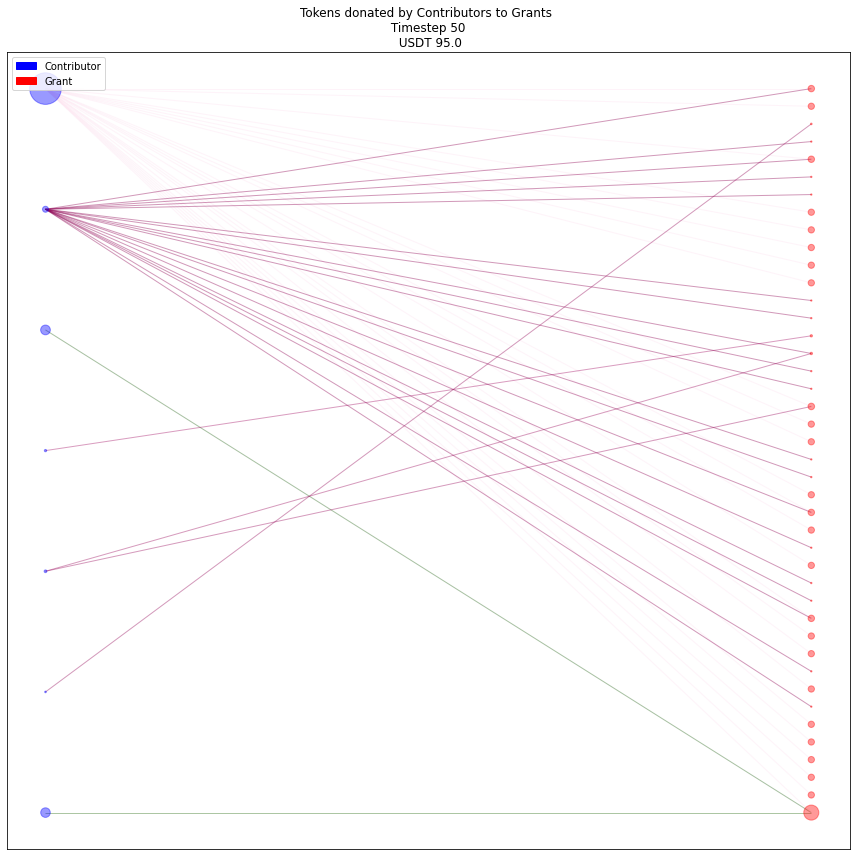

time: 202 ms (started: 2021-02-18 09:43:43 +01:00)


In [6]:
c = df.contributions.iloc[50:51].values[0]
plot_contributions(c, counter=50)

Above is a [bipartite graph](https://en.wikipedia.org/wiki/Bipartite_graph) of the 1000th time step of the 6000 timestep simulation of the gitcoin data. Below, if uncommented, we can create a video of the graph evolving across the first 1000 timesteps.

In [23]:
# create_video_snap(df.contributions.iloc[1:501])

time: 175 µs (started: 2021-02-17 17:57:51 +01:00)


## Conclusion

In this notebook, we've imported the pickled cadCAD model results from the first 6000 timesteps of the Gitcoin Grants Round 7 data, plotted, and analyzed their results. 